# Estimating participants' disease stages

>Next, I'd get it working with less and less information assumed to be known. You could either start inferring the participant's stage of disease or the order for biomarkers next. I'd probably do the participant's state of disease.

>For the stage of disease for a participant, I'd do probably derive a gibbs sampling step by calculating each stage's relative likelihood based on the probabilities of the biomarker values ASSUMING they are at that stage. Then you normalize and sample from that discrete distribution.  

## Known $\theta$ and $\phi$

First, let us assume that we know $\theta$ and $\phi$. We also know at which disease stage a biomarker is affected (i.e., $S_n$). Basically, in the `data` below, we do not have these two columns: `k_j` and `affected_or_not`. 

For each participant, I will iterate through all possible stages. For each stage, I will calculate the likelihood of seeing the observed sequence of biomarker values using the following formula:

$$p(X_{j} | S , z_j = 1, k_j) = \prod_{i=1}^{k_j}{p(X_{S(i)j} \mid \theta_n )} \prod_{i=k_j+1}^N{p(X_{S(i)j} \mid \phi_n)}$$


In [1]:
import pandas as pd 
import numpy as np 
import re 
import altair as alt 
import matplotlib.pyplot as plt 
from scipy.stats import mode
data = pd.read_csv('data/participant_data.csv')
# data.Biomarker = [re.sub("Biomarker ", "", text) for text in data.Biomarker.tolist()]
data['Diseased'] = data.apply(lambda row: row.k_j > 0, axis = 1)
data.head()
# but remember that we do not know k_j which is what we are trying to estimate. 

,participant,biomarker,measurement,k_j,S_n,affected_or_not,Diseased
0,0,MMSE,27.506251,8,5,affected,True
1,1,MMSE,20.177897,1,5,not_affected,True
2,2,MMSE,27.821436,10,5,affected,True
3,3,MMSE,27.799397,9,5,affected,True
4,4,MMSE,20.916698,3,5,not_affected,True


In [2]:
# participant id: stage
actual_participant_stage_dic = dict(zip(data.participant, data.k_j))

participants = data.participant.unique()

# 11 stages in total, [0, 10].
num_stages = len(data.k_j.unique())

# biomarkers
biomarkers = np.array(data.biomarker.unique())

## These are the healthy participants (Participant ID)
non_diseased_participants = list(set(data.loc[data.Diseased == False].participant))

In [3]:
non_diseased_participants

[67, 69, 39, 9, 10, 81, 51, 20, 24, 27]

Note that in `participant_data.csv`, $S_n \geq 1$ because $S_n$ means the disease stage associated with a specific biomarker. $k_j \geq 0$, indicating that participants may not be in any of the 10 disease stages (i.e., when $k_j = 0$). 

In [4]:
data.S_n.unique()

array([ 5,  6,  3,  4,  1,  7,  8,  2,  9, 10])

In [5]:
data.k_j.unique()

array([ 8,  1, 10,  9,  3,  5,  4,  0,  6,  7,  2])

In [6]:
theta_phi = pd.read_csv('data/means_stds.csv')
theta_phi

,biomarker,theta_mean,theta_std,phi_mean,phi_std
0,MMSE,28.0,0.666667,22.0,2.666667
1,ADAS,-6.0,1.333333,-20.0,4.000000
2,AB,250.0,50.000000,150.0,16.666667
3,P-Tau,-25.0,16.666667,-50.0,33.333333
4,HIP-FCI,5.0,1.666667,-5.0,6.666667
5,HIP-GMI,0.4,0.233333,0.3,0.333333
6,AVLT-Sum,40.0,15.000000,20.0,6.666667
7,PCC-FCI,12.0,4.000000,5.0,3.333333
8,FUS-GMI,0.6,0.066667,0.5,0.066667
9,FUS-FCI,-10.0,3.333333,-20.0,6.000000


In [7]:
def compute_single_measurement_likelihood(theta_phi, biomarker, affected, measurement):
    '''Computes the likelihood of the measurement value of a single biomarker
    We know the normal distribution defined by either theta or phi
    and we know the measurement. This will give us the probability
    of this given measurement value. 

    input:
    - theta_phi: the dataframe containing theta and phi values for each biomarker
    - biomarker: a string of biomarker name
    - affected: a boolean 
    - measurement: the observed value for a biomarker in a specific participant

    output: a scalar
    '''
    biomarker_params = theta_phi[theta_phi.biomarker == biomarker].reset_index()
    mu = biomarker_params['theta_mean'][0] if affected else biomarker_params['phi_mean'][0]
    std = biomarker_params['theta_std'][0] if affected else biomarker_params['phi_std'][0]
    likelihood = np.exp(-(measurement - mu)**2/(2*std**2))/np.sqrt(2*np.pi*std**2)
    return likelihood

In [8]:
def compute_likelihood(pdata, k_j, theta_phi):
    '''This implementes the formula of https://ebm-book2.vercel.app/distributions.html#known-k-j
    Inputs:
        - pdata: data that belongs to a specific participant
        - k_j: the disease stage the participant is at 
        - theta_phi: a dataframe containing theta and phi means & vars for all biomarkers
    Outputs:
        - the likelihood of seeing this sequence of measurements if the participant is at this k_j
    '''
    likelihood = 1
    for i, row in pdata.iterrows():
        biomarker = row['biomarker']
        measurement = row['measurement']
        affected = k_j >= row['S_n']
        likelihood *= compute_single_measurement_likelihood(
            theta_phi, biomarker, affected, measurement)
    return likelihood

## Cases when our algorithm does not work

In [9]:
# These are the participants whose results using our algorithm 
# generates different stages than actual stages

p_ids_with_different_results = [4,  5,  6,  9, 10, 13, 14, 16, 18, 20, 21, 24, 26, 30, 34, 35, 39,
        41, 45, 46, 47, 49, 52, 58, 59, 61, 66, 68, 69, 71, 72, 76, 80, 81,
        84, 85, 89, 92, 94, 97, 98]

In [10]:
participant_index = np.random.choice(p_ids_with_different_results)
p_data = data[data.participant == participant_index].reset_index(drop=True)
p_data

,participant,biomarker,measurement,k_j,S_n,affected_or_not,Diseased
0,35,MMSE,26.622648,7,5,affected,True
1,35,ADAS,-5.208188,7,6,affected,True
2,35,AB,176.983674,7,3,affected,True
3,35,P-Tau,-45.907050,7,4,affected,True
4,35,HIP-FCI,5.216175,7,1,affected,True
5,35,HIP-GMI,0.294745,7,7,affected,True
6,35,AVLT-Sum,25.589763,7,8,not_affected,True
7,35,PCC-FCI,16.988087,7,2,affected,True
8,35,FUS-GMI,0.477831,7,9,not_affected,True
9,35,FUS-FCI,-18.246332,7,10,not_affected,True


In [11]:
num_stages = len(data.k_j.unique())
stage_likelihood = np.zeros(num_stages)
for k in range(num_stages):
    # assume participant is in this stage; compute the likelihood of seeing 
    # this sequence of observed biomarker measurement
    # [0, 10] Note that k CAN be 0
    likelihood = compute_likelihood(p_data, k, theta_phi=theta_phi)
    stage_likelihood[k] = likelihood
p_stage_likelihood_df = pd.DataFrame(stage_likelihood, columns=['likelihood'])
p_stage_likelihood_df.sort_values(by = "likelihood", ascending=False)

,likelihood
7,1.357054e-10
6,1.051545e-10
8,5.403394e-11
9,1.065259e-11
10,9.382050e-13
2,5.401699e-14
5,4.485699e-14
3,2.298917e-14
4,2.109256e-14
1,2.191523e-16


## For all participants

In [12]:
def update_estimaged_participant_stage_dic(num_stages, p, p_data, theta_phi, estimated_participant_stage_dic):
    # initiaze stage_likelihood
    stage_likelihood = np.zeros(num_stages)
    for k in range(num_stages):
        # assume participant is in this stage; compute the likelihood of seeing 
        # this sequence of observed biomarker measurement
        # [0, 10] Note that k CAN be 0
        likelihood = compute_likelihood(p_data, k, theta_phi=theta_phi)
        stage_likelihood[k] = likelihood
    # estimated_participant_stage_dic[p] = np.argmax(stage_likelihood)
    likelihood_sum = np.sum(stage_likelihood)
    normalized_stage_likelihood = [l/likelihood_sum for l in stage_likelihood]
    sampled_stage = np.random.choice(np.arange(num_stages), p = normalized_stage_likelihood)
    estimated_participant_stage_dic[p] = sampled_stage        

Note that if I run the algorithm once, the `sampled_stage` might not be the one with highest probability. So I did with multiple iterations. I obtained multiple `estimated_participant_stage_dic`. Then I used the mode for each participant. However, still, the results are not optimal. I do not understand why. 

In [13]:
num_iterations = 2
estimated_participant_stage_dic = {}
estimated_participant_stage_dic_list = []

for _ in range(num_iterations):
    for p in participants:
        p_data = data[data.participant == p].reset_index(drop=True)
        update_estimaged_participant_stage_dic(
            num_stages, p, p_data, theta_phi, estimated_participant_stage_dic)
    estimated_participant_stage_dic_list.append(estimated_participant_stage_dic)

In [14]:
lists_of_values_array = []
for dic in estimated_participant_stage_dic_list:
    values_array = np.array(list(dic.values()))
    lists_of_values_array.append(values_array)
# len(lists_of_values_array)
stacked_lists_of_values_array = np.stack(lists_of_values_array, axis = 0)
# stacked_lists_of_values_array.shape
estimated_stages = mode(stacked_lists_of_values_array, axis=0, keepdims=False)[0]

In [15]:
# estimated_stages = np.array(list(estimated_participant_stage_dic.values()))
actual_stages = np.array(list(actual_participant_stage_dic.values()))
differences = estimated_stages - actual_stages
# non_zero_indices = np.nonzero(differences)
# non_zero_indices

In [16]:
differences

array([ 0,  0,  0,  0,  0,  0, -1, -1,  1,  0,  0, -1,  0,  0, -1, -1,  0,
        1,  0,  0,  0,  1,  0, -2,  0,  1, -1,  1,  0, -1,  1,  0,  0,  0,
        0,  0,  2,  0, -2,  0,  0,  0,  2,  0,  0,  0,  1,  4,  3, -4,  0,
        0, -2,  1,  1,  0,  0,  1,  0,  0,  2, -1,  1,  1, -4,  0,  0,  0,
        0,  0, -1,  0,  0,  1,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,
       -1,  0,  1,  0,  0,  0,  1, -2,  0,  0, -1,  0,  0,  0, -1])

In [17]:
def scatter_plot_of_stage_differences(stage_differences):
    '''Scatter Plot of the Difference at each index
    Input:
    - stage_differences: estimated_stages - actual stages. Result should be a 1-dim np array
    '''
    plt.figure(figsize=(10, 6))
    plt.scatter(range(100), stage_differences, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title("Scatter Plot of Stage Difference for Each Participant")
    plt.xlabel("Participant")
    plt.ylabel("Difference (Estimated Stage - True Stage)")
    plt.grid(True)
    plt.show()

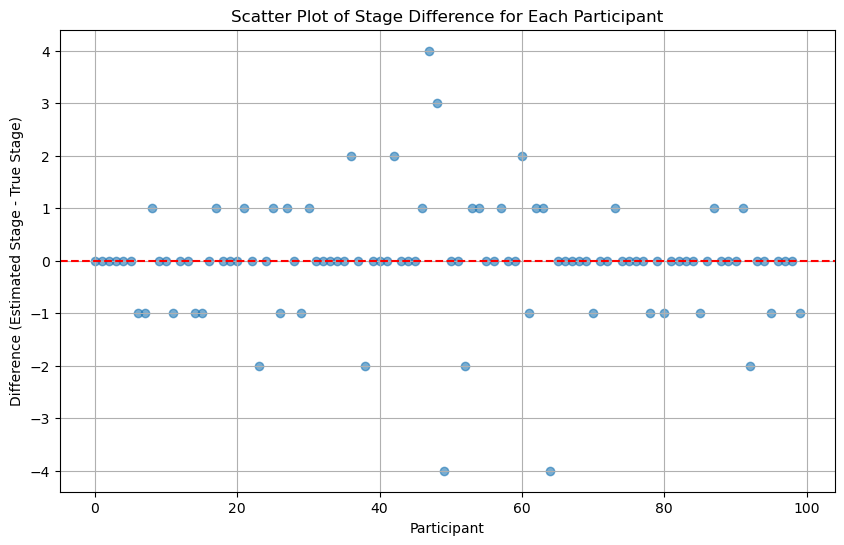

In [18]:
scatter_plot_of_stage_differences(differences)

From the above figure, it is clear that the method we employed successfully estimated the stage each participant is in.

## Unknown $\theta$ and $\phi$

Suppose we do not have access to the parameters for biomarker value distributions; i.e., we do not know $\theta$ and $\phi$. 

In [19]:
data_we_have = data.drop(['k_j', 'affected_or_not'], axis = 1)
data_we_have.head()

,participant,biomarker,measurement,S_n,Diseased
0,0,MMSE,27.506251,5,True
1,1,MMSE,20.177897,5,True
2,2,MMSE,27.821436,5,True
3,3,MMSE,27.799397,5,True
4,4,MMSE,20.916698,5,True


In [20]:
def fill_up_data_we_have(data_we_have, participant_stages, participants):
    '''This is to fill up data_we_have. 
    Basically, add two columns: k_j, and affected, based on the initial or updated participant_stages
    Essentially, all we do below is to get the most accurate participant_stages

    Note: we do not have the real participant_stages right now. 
    
    Inputs:
        - data_we_have
        - participant_stages: np array 
        - participants: 0-99
    '''
    participant_stage_dic = dict(zip(np.arange(0,len(participants)), participant_stages))
    data_we_have['k_j'] = data_we_have.apply(lambda row: participant_stage_dic[row.participant], axis = 1)
    data_we_have['affected'] = data_we_have.apply(lambda row: row.k_j >= row.S_n, axis = 1)
    return data_we_have 

In [21]:
def estimate_params_exact(m0, n0, s0_sq, v0, data):
    '''This is to estimate means and vars based on conjugate priors
    Inputs:
        - data: a vector of measurements 
        - m0: prior estimate of $\mu$.
        - n0: how strongly is the prior belief in $m_0$ is held.
        - s0_sq: prior estimate of $\sigma^2$.
        - v0: prior degress of freedome, influencing the certainty of $s_0^2$.
    
    Outputs:
        - mu estiate, std estimate
    '''
    # Data summary
    sample_mean = np.mean(data)
    sample_size = len(data)
    sample_var = np.var(data, ddof=1)  # ddof=1 for unbiased estimator

    # Update hyperparameters for the Normal-Inverse Gamma posterior
    updated_m0 = (n0 * m0 + sample_size * sample_mean) / (n0 + sample_size)
    updated_n0 = n0 + sample_size
    updated_v0 = v0 + sample_size 
    updated_s0_sq = (1 / updated_v0) * ((sample_size - 1) * sample_var + v0 * s0_sq + 
                    (n0 * sample_size / updated_n0) * (sample_mean - m0)**2)
    updated_alpha = updated_v0/2
    updated_beta = updated_v0*updated_s0_sq/2

    # Posterior estimates
    mu_posterior_mean = updated_m0
    sigma_squared_posterior_mean = updated_beta/updated_alpha

    mu_estimation = mu_posterior_mean
    std_estimation = np.sqrt(sigma_squared_posterior_mean)

    return mu_estimation, std_estimation

In [22]:
def get_estimated_means_stds_df(biomarkers, data_we_have):
    '''To get estimated parameters, returns a Pandas DataFrame
    Input:
    - biomarkers: biomarkers 
    - data_we_have: participants data filled with initial or updated participant_stages

    Output: 
    - estimate_means_std_df, just like means_stds_df, containing the estimated mean and std_dev for 
      distribution of biomarker values when the biomarker is affected and not affected
    '''
     # empty list of dictionaries to store the estimates 
    means_stds_estimate_dict_list = []
    
    for biomarker in biomarkers: 
        dic = {'biomarker': biomarker}  # Initialize dictionary outside the inner loop
        for affected in [True, False]:
            data_full = data_we_have[(data_we_have.biomarker == biomarker) & (
            data_we_have.affected == affected)]
            data = data_full.measurement
            mu_estimate, std_estimate = estimate_params_exact(
                m0 = 0, n0 = 1, s0_sq = 1, v0 = 1, data=data)
            if affected:
                dic['theta_mean'] = mu_estimate
                dic['theta_std'] = std_estimate
            else:
                dic['phi_mean'] = mu_estimate
                dic['phi_std'] = std_estimate
        # print(f"biomarker {biomarker} done!")
        means_stds_estimate_dict_list.append(dic)
    estimate_means_stds_df = pd.DataFrame(means_stds_estimate_dict_list)
    return estimate_means_stds_df 

### Randomized initilization

A potential bug occurs here: suppose in one iteration, among `participant_stages`, there is only one participant whose stage is $10$. In this situation, biomarker FUS-FCI which corresponses to stage 10, has only one measurement for `affected==True`, and we cannot obtain the std of FUS-FCI. 

In [23]:
num_stages

11

In [24]:
# initialize participant_stages 
# num_stages = 11 as earlier defined
participant_stages = np.random.randint(low = 0, high = num_stages, size = len(participants))

# this is what we already know
participant_stages[non_diseased_participants] = 0

In [25]:
def count_10s(array):
    """Count how many 10 are in an array
    """
    return np.count_nonzero(array == 10)

def df_contains_nan(df):
    """check whether a dataframe contains nan 
    """
    return df.isnull().values.any()

In [26]:
count_10s(actual_stages)

13

In [27]:
num_iterations = 2
for i in range(num_iterations):
    print(f"Number of participants in stage 10: {count_10s(participant_stages)}")
    # fill up data_we_have with the current participant_stages
    data_we_have = fill_up_data_we_have(data_we_have, participant_stages, participants)
    estimated_means_stds_df = get_estimated_means_stds_df(biomarkers, data_we_have)
    print(f"There are nan values in estimated_means_stds_df: {df_contains_nan(estimated_means_stds_df)}")
    for p in participants:
        # update participant_stages ONLY IF we do NOT know its k_j
        if p not in non_diseased_participants:
            p_data = data_we_have[data_we_have.participant == p].reset_index(drop=True)
            # initiaze stage_likelihood
            stage_likelihood = np.zeros(num_stages)
            # note that it should be [0, 10]
            for k in range(num_stages):
            # [0, 10] Note that k CAN be 0
                likelihood = compute_likelihood(p_data, k, theta_phi = estimated_means_stds_df)
                stage_likelihood[k] = likelihood
            likelihood_sum = np.sum(stage_likelihood)
            try:
                normalized_stage_likelihood = [l/likelihood_sum for l in stage_likelihood]
            except:
                print(stage_likelihood)
            sampled_stage = np.random.choice(np.arange(num_stages), p = normalized_stage_likelihood)
            participant_stages[p] = sampled_stage         
    print(f"iteration {i} done")

Number of participants in stage 10: 7
There are nan values in estimated_means_stds_df: False


iteration 0 done
Number of participants in stage 10: 6
There are nan values in estimated_means_stds_df: False


iteration 1 done


In [28]:
participant_stages = np.array([ 6,  5,  3,  4,  8,  8,  6,  0,  9,  4,  7,  8,  8,  2,  2,  4,  8,
        2,  6,  5,  7,  3,  4,  6,  7,  8,  0,  0,  5,  7,  2,  9,  0, 10,
        1,  7,  3,  3,  7,  2,  0,  6,  4,  0,  2,  0,  8,  6,  5,  7,  6,
        9,  8,  3,  7,  9,  6,  9,  8,  9,  9,  1,  0,  5,  2,  7,  5,  7,
        8,  8,  7,  5,  6,  9,  3,  5,  2,  3,  5,  1,  8,  7,  3,  5,  7,
        0,  7,  4,  3,  6,  5,  0,  2,  0,  4,  1,  5,  1,  6,  1])
data_we_have = data.drop(['k_j', 'affected_or_not'], axis = 1)
data_we_have = fill_up_data_we_have(data_we_have, participant_stages, participants)
data_full = data_we_have[(data_we_have.biomarker == "FUS-FCI") & (data_we_have.affected == True)]
data_full

,participant,biomarker,measurement,S_n,Diseased,k_j,affected
933,33,FUS-FCI,-21.911051,10,True,10,True


In [29]:
estimated_means_stds_df = get_estimated_means_stds_df(biomarkers, data_we_have)
estimated_means_stds_df

,biomarker,theta_mean,theta_std,phi_mean,phi_std
0,MMSE,24.885453,4.771776,24.985951,5.153831
1,ADAS,-13.658623,7.959763,-13.378380,7.648926
2,AB,223.414988,67.034433,228.003354,75.845095
3,P-Tau,-33.859043,30.360922,-30.301946,23.529622
4,HIP-FCI,3.820403,4.453431,3.752868,1.659641
5,HIP-GMI,0.423110,0.343135,0.315138,0.318710
6,AVLT-Sum,25.996995,12.472141,24.921190,14.545308
7,PCC-FCI,11.009824,4.576494,9.299180,5.222394
8,FUS-GMI,0.478496,0.358865,0.519289,0.138932
9,FUS-FCI,-10.955525,NaN,-18.532568,6.521639


### Result after gibbs sampling

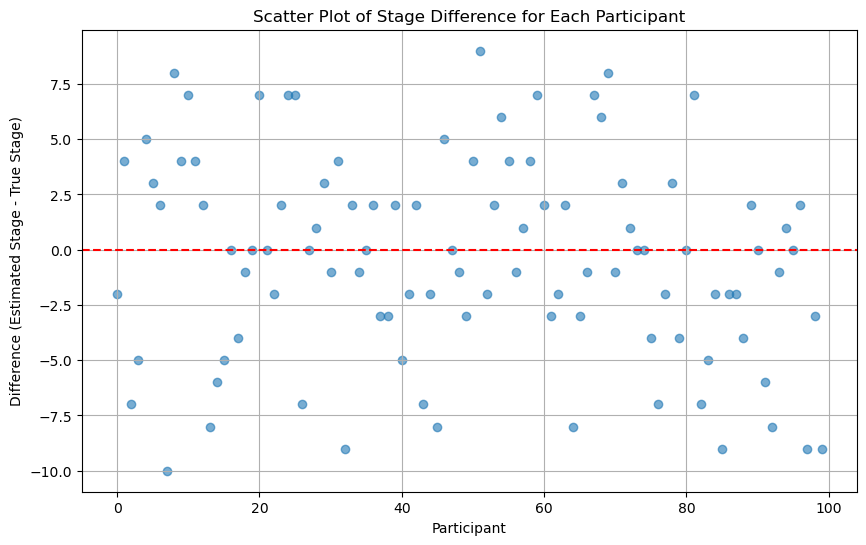

In [30]:
estimated_stages = participant_stages
actual_stages = np.array(list(actual_participant_stage_dic.values()))
differences = estimated_stages - actual_stages
scatter_plot_of_stage_differences(differences)

### Trying initializing participant stages as the actual stages

We can see that if we initlize participant stages as the actual stages, the result is much better. 

In [31]:
participant_stages = actual_stages
for i in range(num_iterations):
    # fill up data_we_have with current participant_stages
    data_we_have = fill_up_data_we_have(data_we_have, participant_stages, participants)
    estimated_means_stds_df = get_estimated_means_stds_df(biomarkers, data_we_have)
    for p in participants:
        p_data = data_we_have[data_we_have.participant == p].reset_index(drop=True)
        # initiaze stage_likelihood
        stage_likelihood = np.zeros(num_stages)
        # note that it is [0, 10]
        for k in range(num_stages):
            likelihood = compute_likelihood(p_data, k, theta_phi = estimated_means_stds_df)
            stage_likelihood[k] = likelihood
        likelihood_sum = np.sum(stage_likelihood)
        normalized_stage_likelihood = [l/likelihood_sum for l in stage_likelihood]
        sampled_stage = np.random.choice(np.arange(num_stages), p = normalized_stage_likelihood)
        participant_stages[p] = sampled_stage         
    print(f"iteration {i} done")

iteration 0 done


iteration 1 done


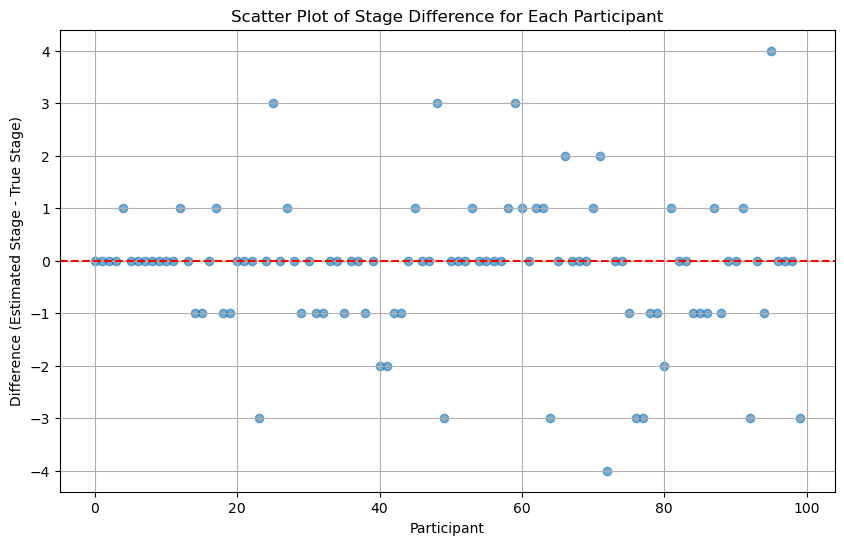

In [32]:
estimated_stages = participant_stages
actual_stages = np.array(list(actual_participant_stage_dic.values()))
differences = estimated_stages - actual_stages
scatter_plot_of_stage_differences(differences)